# Tweet Turing Test: Detecting Disinformation on Twitter  

|          | Group #2 - Disinformation Detectors                     |
|---------:|---------------------------------------------------------|
| Members  | John Johnson, Katy Matulay, Justin Minnion, Jared Rubin |
| Notebook | `06_feature_engineering.ipynb`                        |
| Purpose  | Feature Engineering for ML models                |

(todo: description)

# 1 - Setup

In [1]:
# imports from Python standard library

# imports requiring installation
#   connection to Google Cloud Storage
from google.cloud import storage            # pip install google-cloud-storage
from google.oauth2 import service_account   # pip install google-auth

#  data science packages
import numpy as np                          # pip install numpy
import pandas as pd                         # pip install pandas

In [2]:
!pip install demoji
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
import demoji
import seaborn as sns
import nltk
from datetime import date
import regex as re
import pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 KB 1.4 MB/s eta 0:00:00


In [3]:
#Colab Specific workflow - remove for github
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# pandas options
pd.set_option('display.max_colwidth', None)

## Local or Cloud?

Decide here whether to run notebook with local data or GCP bucket data
 - if the working directory of this notebook has a "../data/" folder with data loaded (e.g. working on local computer or have data files loaded to a cloud VM) then use the "local files" option and comment out the "gcp bucket files" option
 - if this notebook is being run from a GCP VM (preferrably in the `us-central1` location) then use the "gcp bucket files" option and comment out the "local files" option

In [ ]:
# option: local files
local_or_cloud: str = "local"   # comment/uncomment this line or next

# option: gcp bucket files
#local_or_cloud: str = "cloud"   # comment/uncomment this line or previous

# don't comment/uncomment for remainder of cell
if (local_or_cloud == "local"):
    data_paths = local_data_paths
    snapshot_paths = local_snapshot_paths
elif (local_or_cloud == "cloud"):
    data_paths = gcp_data_paths
    snapshot_paths = gcp_snapshot_paths
else:
    raise ValueError("Variable 'local_or_cloud' can only take on one of two values, 'local' or 'cloud'.")
    # subsequent cells will not do this final "else" check

In [ ]:
# this cell only needs to run its code if local_or_cloud=="cloud"
#   (though it is harmless if run when local_or_cloud=="local")
gcp_storage_client: storage.Client = None
gcp_bucket: storage.Bucket = None

if (local_or_cloud == "cloud"):
    gcp_storage_client = tur.get_gcp_storage_client(project_name=gcp_project_name, key_file=gcp_key_file)
    gcp_bucket = tur.get_gcp_bucket(storage_client=gcp_storage_client, bucket_name=gcp_bucket_name)

## 2 - Load EDA Export Dataset

Sampled dataset, as prepared by prior notebook `04_nlp_preprocess.ipynb`, will be loaded as "`data`".
Full dataset, as prepared by `03_eda.ipynb`, will be loaded as "`df`".

In [6]:
#Colab Specific workflow - remove for github

#Google Drive url for data file
file_folder = '/content/gdrive/MyDrive/Grad School/DSCI592/data/'

#### 10% Sampled Dataset

In [ ]:
#Colab Specific workflow - remove for github

#Read in the parquet file of the 10% sample dataset
data = pd.read_parquet(file_folder+'2data_sample_ten_percent.parquet.gz')
#data = pd.read_parquet('/content/gdrive/MyDrive/Grad School/DSCI592/data/2data_sample_ten_percent.parquet.gz')

#### Full dataset

In [6]:
#Colab Specific workflow - remove for github

#complete dataset is df
df = pd.read_parquet(file_folder +'data_after_03_eda.parquet.gz')

In [8]:
df.columns

Index(['external_author_id', 'author', 'content', 'region', 'language',
       'following', 'followers', 'updates', 'post_type', 'is_retweet',
       'account_category', 'tweet_id', 'tco1_step1', 'data_source', 'has_url',
       'emoji_text', 'emoji_count', 'publish_date', 'class', 'following_ratio',
       'class_numeric', 'RUS_lett_count'],
      dtype='object')

## 3 - Feature Engineering

#### 3a - Binary Emoji Features:


Emoji text will be used to derive binary features for the Top 17 most frequently appearing emojis.

In [ ]:
#Convert emoji_text to string object in order to use regex
data['emoji_text']=data['emoji_text'].astype(str)
data.dtypes

external_author_id                 string
author                             string
content                            string
region                             string
language                         category
following                          uint64
followers                          uint64
updates                            uint64
post_type                        category
is_retweet                        float64
account_category                 category
tweet_id                           string
tco1_step1                         string
data_source                      category
has_url                             int64
emoji_text                         object
emoji_count                         int64
publish_date          datetime64[ns, UTC]
class                            category
following_ratio                   float64
class_numeric                        int8
RUS_lett_count                      int64
dtype: object

In [ ]:
#confirm string
data[data['emoji_count']>0]['emoji_text'][:8]

24                                                           ['tornado' 'flexed biceps']
48                                                  ['face with open mouth' 'thumbs up']
79                                                                 ['red question mark']
94                                                                              ['bear']
106    ['thumbs up' 'flag: United States' 'flag: United States'\n 'flag: United States']
112                                                                   ['hundred points']
113                                                                       ['check mark']
165                                                                            ['skull']
Name: emoji_text, dtype: object

In [ ]:
#Create small sample to test regex
emoji_test=data[data['emoji_count']>0][:10]

emoji_test['emoji_text']

24                                                           ['tornado' 'flexed biceps']
48                                                  ['face with open mouth' 'thumbs up']
79                                                                 ['red question mark']
94                                                                              ['bear']
106    ['thumbs up' 'flag: United States' 'flag: United States'\n 'flag: United States']
112                                                                   ['hundred points']
113                                                                       ['check mark']
165                                                                            ['skull']
173                                    ['evergreen tree' 'fish' 'evergreen tree' 'deer']
183                                                                      ['soccer ball']
Name: emoji_text, dtype: object

In [ ]:
emoji_test['emoji_flagUS'] = emoji_test.emoji_text.apply(lambda x: 1 if re.findall('flag: United States',x) else 0)
emoji_test['emoji_police'] = emoji_test.emoji_text.apply(lambda x: 1 if re.findall('police car light',x) else 0)
emoji_test['emoji_check']= emoji_test.emoji_text.apply(lambda x: 1 if re.findall('check mark',x) else 0)
emoji_test['emoji_exclamation'] = emoji_test.emoji_text.apply(lambda x: 1 if re.findall('double exclamation mark',x) else 0)  
emoji_test['emoji_fist'] = emoji_test.emoji_text.apply(lambda x: 1 if re.findall('raised fist',x) else 0)  
emoji_test['emoji_collision'] = emoji_test.emoji_text.apply(lambda x: 1 if re.findall('collision',x) else 0) 
emoji_test['emoji_prohibited'] = emoji_test.emoji_text.apply(lambda x: 1 if re.findall('prohibited',x) else 0) 

In [ ]:
emoji_test['emoji_troll']=emoji_test.emoji_text.apply(lambda x: 1 if re.findall('flag: United States',x) 
or re.findall('police car light',x)
or re.findall('check mark',x)
or re.findall('double exclamation mark',x)
or re.findall('raised fist',x) 
or re.findall('collision',x)
or re.findall('prohibited',x) else 0)

In [ ]:
emoji_test['emoji_troll2']= emoji_test.emoji_text.apply(lambda x: 1 if re.findall(r'flag: United States|check mark|police car light| double exclamation mark|raised fist|collision|prohibited', x) else 0)

In [ ]:
emoji_test['emoji_troll2']

24     0
48     0
79     0
94     0
106    1
112    0
113    1
165    0
173    0
183    0
Name: emoji_troll2, dtype: int64

#### Pre-process Emojis Sub-sampled dataset

In [ ]:
troll_emojis= ['flag: United States','police car light','check mark','double exclamation mark','raised fist','collision','prohibited']

In [ ]:
data['emoji_flagUS'] = data.emoji_text.apply(lambda x: 1 if re.findall('flag: United States',x) else 0)
data['emoji_police'] = data.emoji_text.apply(lambda x: 1 if re.findall('police car light',x) else 0)
data['emoji_check']= data.emoji_text.apply(lambda x: 1 if re.findall('check mark',x) else 0)
data['emoji_exclamation'] = data.emoji_text.apply(lambda x: 1 if re.findall('double exclamation mark',x) else 0)  
data['emoji_fist'] = data.emoji_text.apply(lambda x: 1 if re.findall('raised fist',x) else 0)  
data['emoji_collision'] = data.emoji_text.apply(lambda x: 1 if re.findall('collision',x) else 0) 
data['emoji_prohibited'] = data.emoji_text.apply(lambda x: 1 if re.findall('prohibited',x) else 0) 

In [ ]:
#validate
data['emoji_flagUS'].value_counts()
data['emoji_check'].value_counts()
data['emoji_exclamation'].value_counts()
data['emoji_fist'].value_counts()
data['emoji_prohibited'].value_counts()
data['emoji_police'].value_counts()
data['emoji_collision'].value_counts()

0    362190
1       124
Name: emoji_collision, dtype: int64

In [ ]:
#export to parquet file
import pyarrow
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/data_sample_ten_percent_emojis.parquet.gz'
data.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

#### 3a - Binary Emoji Features Pre-process emojis on entire dataset

In [9]:
#Convert emoji_text to string object in order to use regex
df['emoji_text']=df['emoji_text'].astype(str)
df.dtypes

external_author_id                 string
author                             string
content                            string
region                             string
language                         category
following                          uint64
followers                          uint64
updates                            uint64
post_type                        category
is_retweet                        float64
account_category                 category
tweet_id                           string
tco1_step1                         string
data_source                      category
has_url                             int64
emoji_text                         object
emoji_count                         int64
publish_date          datetime64[ns, UTC]
class                            category
following_ratio                   float64
class_numeric                        int8
RUS_lett_count                      int64
dtype: object

In [10]:
#validate string
df[df['emoji_count']>0]['emoji_text'][:3]


4                ['flag: United States']
6     ['honeybee' 'honeybee' 'honeybee']
16             ['red heart' 'red heart']
Name: emoji_text, dtype: object

In [11]:
#encode original 7 troll emojis as binary features to denote if emoji is present in text
df['emoji_flagUS'] = df.emoji_text.apply(lambda x: 1 if re.findall('flag: United States',x) else 0)
df['emoji_police'] = df.emoji_text.apply(lambda x: 1 if re.findall('police car light',x) else 0)
df['emoji_check']= df.emoji_text.apply(lambda x: 1 if re.findall('check mark',x) else 0)
df['emoji_exclamation'] = df.emoji_text.apply(lambda x: 1 if re.findall('double exclamation mark',x) else 0)  
df['emoji_fist'] = df.emoji_text.apply(lambda x: 1 if re.findall('raised fist',x) else 0)  
df['emoji_collision'] = df.emoji_text.apply(lambda x: 1 if re.findall('collision',x) else 0) 
df['emoji_prohibited'] = df.emoji_text.apply(lambda x: 1 if re.findall('prohibited',x) else 0) 

In [12]:
#additional emojis were decided to be encoded based on entire dataset emoji frequency
df['emoji_loudcryface'] = df.emoji_text.apply(lambda x: 1 if re.findall('loudly crying face',x) else 0)
df['emoji_smilinghearteye'] = df.emoji_text.apply(lambda  x: 1 if re.findall('smiling face with heart-eyes',x) else 0)
df['emoji_fire'] = df.emoji_text.apply(lambda x: 1 if re.findall('fire',x) else 0)
df['emoji_redheart']= df.emoji_text.apply(lambda x: 1 if re.findall('red heart',x) else 0)
df['emoji_tearsjoy'] = df.emoji_text.apply(lambda  x: 1 if re.findall('face with tears of joy',x) else 0)
df['emoji_thumbsup'] = df.emoji_text.apply(lambda  x: 1 if re.findall('thumbs up',x) else 0)
df['emoji_claphands'] = df.emoji_text.apply(lambda  x: 1 if re.findall('clapping hands',x) else 0)
df['emoji_blowingkiss'] = df.emoji_text.apply(lambda  x: 1 if re.findall('face blowing a kiss',x) else 0)
df['emoji_partypop'] = df.emoji_text.apply(lambda  x: 1 if re.findall('party popper',x) else 0)
df['emoji_raisehands'] = df.emoji_text.apply(lambda  x: 1 if re.findall('raising hands',x) else 0)

In [13]:
#Export as 03_eda_w_emojis
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/data_after_03_eda_emojis.parquet.gz'
df.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

#### Import df2 with emoji encoding part 1

In [14]:
#import
#df with emoji binary encoding
df2 =pd.read_parquet(file_folder +'data_after_03_eda_emojis.parquet.gz')

In [ ]:
#validate
print('\n emoji_flagUS \n',df2['emoji_flagUS'].value_counts(),
'\n emoji_check \n',df2['emoji_check'].value_counts(),
'\n emoji_exclamation \n',df2['emoji_exclamation'].value_counts(),
'\n emoji_fist \n',df2['emoji_fist'].value_counts(),
'\n emoji_prohibited \n', df2['emoji_prohibited'].value_counts(), 
'\n emoji_police \n', df2['emoji_police'].value_counts(), 
 '\n emoji_collision \n', df2['emoji_collision'].value_counts())


 emoji_flagUS 
 0    3619887
1       5007
Name: emoji_flagUS, dtype: int64 
 emoji_check 
 0    3622092
1       2802
Name: emoji_check, dtype: int64 
 emoji_exclamation 
 0    3622609
1       2285
Name: emoji_exclamation, dtype: int64 
 emoji_fist 
 0    3622107
1       2787
Name: emoji_fist, dtype: int64 
 emoji_prohibited 
 0    3624402
1        492
Name: emoji_prohibited, dtype: int64 
 emoji_police 
 0    3622651
1       2243
Name: emoji_police, dtype: int64 
 emoji_collision 
 0    3623611
1       1283
Name: emoji_collision, dtype: int64


In [15]:
df2.groupby(['emoji_flagUS'])['class'].value_counts()


emoji_flagUS          
0             Troll       2112803
              Verified    1507084
1             Troll          4063
              Verified        944
Name: class, dtype: int64

In [ ]:
#df2.groupby(['class'])['emoji_count'].value_counts().median()
more_emojis= df2[df2['emoji_count']<5]
#more_emojis.groupby(['class']).count()
emoji_test_flag = df2.loc[(df2['emoji_count']<5) & (df2['emoji_flagUS']==1)]


In [ ]:
emoji_test_flag['class'].value_counts()

Troll       3237
Verified     859
Name: class, dtype: int64

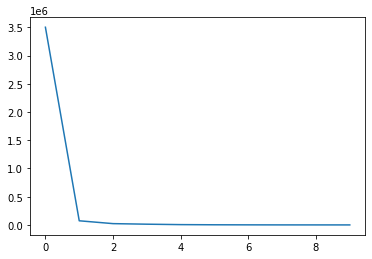

In [ ]:
df2['emoji_count'].value_counts().nlargest(10).plot()

### 3b - Composite feature for emojis (delete, no longer used in model)
Using the previously built emoji features, create a composite column that identifies if any of the previous emoji columns have a 1 then 1.

In [ ]:
#re-run this cell without white space before 'double'!
df2['emoji_troll']= df2.emoji_text.apply(lambda x: 1 if re.findall(r'flag: United States|check mark|police car light|double exclamation mark|raised fist|collision|prohibited', x) else 0)

In [ ]:
#before typo fixed
df2.groupby(['class'])['emoji_troll'].value_counts()

class     emoji_troll
Troll     0              2105581
          1                11285
Verified  0              1505248
          1                 2780
Name: emoji_troll, dtype: int64

In [ ]:
df2.groupby(['class'])['emoji_troll'].value_counts()

class     emoji_troll
Troll     0              2103823
          1                13043
Verified  0              1505019
          1                 3009
Name: emoji_troll, dtype: int64

In [ ]:
#Export as 03_eda_w_emojis2
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/data_after_03_eda_emojis2.parquet.gz'
df2.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

#### Import df3 with both emoji encodings

In [7]:
#import same df2 as df3, since deleting the composite feature
#df with emoji binary encoding
df3 =pd.read_parquet(file_folder +'data_after_03_eda_emojis.parquet.gz')

In [8]:
#import (old)
#df with emoji binary encoding and composite column
df3 = pd.read_parquet(file_folder +'data_after_03_eda_emojis2.parquet.gz')

### 3c - Region
Breaking out region into a binary category for Unknown location. Imputing nulls as Unknown. If null or unknown then 1 else 0.

Imputing nulls as "Unknown" to match with existing category

In [8]:
#fill na with "Unknown"
df3['region'] = df3['region'].fillna('Unknown')

#### Encoding the top 15 regions
Encoding the top 15 regions will cover ~75% of the dataset

In [55]:
df3['region'].value_counts().nlargest(15).sum()/df3['region'].value_counts().sum()

0.7478337297587184

In [56]:
df3['region'].value_counts().nlargest(15)

United States             1906588
Unknown                    421147
Washington, DC              95828
New York, NY                67175
United Kingdom              26881
Washington, D.C.            26340
Los Angeles, CA             21664
Boston, MA                  21310
London                      20968
New York and the World      19368
New York City               18992
Pale Blue Dot               17583
Atlanta, GA                 16580
Australia                   15804
Global                      14590
Name: region, dtype: Int64

In [9]:
#examine class ratios of Unknown region
df_unknown= df3.loc[df3['region'] =='Unknown',['class']]
df_unknown['class'].value_counts()

Troll       242089
Verified    179058
Name: class, dtype: int64

In [20]:
df_United_States = df3.loc[df3['region'] =='United States', ['class']]
df_United_States['class'].value_counts()

Troll       1844450
Verified      62138
Name: class, dtype: int64

In [24]:
df3.loc[df3['region']=='New York, NY',['class']].value_counts()

class   
Verified    67175
Troll           0
dtype: int64

DELETE MOVED INTO NEW SECTION

In [14]:
#create new feature 'unknown_location' using 1 if region = 'Unknown' else 0
#df3['region_unknown']= df3['region'].apply(lambda x: 1 if x =='Unknown' else 0)
#df3['region_unknown'].value_counts()

0    3203747
1     421147
Name: region_unknown, dtype: int64

Extract the list of regions

In [10]:
#extract the list of names of top 15 regions and clean up to use proper column names
regions=df3['region'].value_counts().nlargest(15)
regions_top15 = regions.index
print(regions_top15)

Index(['United States', 'Unknown', 'Washington, DC', 'New York, NY',
       'United Kingdom', 'Washington, D.C.', 'Los Angeles, CA', 'Boston, MA',
       'London', 'New York and the World', 'New York City', 'Pale Blue Dot',
       'Atlanta, GA', 'Australia', 'Global'],
      dtype='object')


In [11]:
#REGEX to clean up region names into column names
regions_fixed = []
for s in regions_top15:
  s = re.sub(r"\s+", '_', s)  ##remove whitespace, replace with "_"
  s = re.sub(r",", "", s)     ## removes ","
  s = re.sub(r"\.","",s)       ## removes "."
  regions_fixed.append('region_'+s)
  #print(s)
#print(regions_top15)
print(regions_fixed)

['region_United_States', 'region_Unknown', 'region_Washington_DC', 'region_New_York_NY', 'region_United_Kingdom', 'region_Washington_DC', 'region_Los_Angeles_CA', 'region_Boston_MA', 'region_London', 'region_New_York_and_the_World', 'region_New_York_City', 'region_Pale_Blue_Dot', 'region_Atlanta_GA', 'region_Australia', 'region_Global']


We will create 15 new columns to represent the regions as binary features, one column `region_All_Other` will be a catchall for any value not in the top 15.

In [13]:
'''iterate through list of top 15 regions, use regex to format the column names, 
then lambda function to determine if region column contains value in list then 1 else 0'''

for i in regions_top15:
    s = re.sub(r"\s+", '_', i)  ##remove whitespace, replace with "_"
    #print(s)
    s = re.sub(r",", "", s)     ## removes ","
   # print(s)
    s = re.sub(r"\.","",s)       ## removes "."
    s= 'region_'+s
   # print(s)
    df3[s] = df3['region'].apply(lambda x: 1 if x==i else 0)

#fix issues with the dupe Washington DC entries not combining
df3 = df3.drop(columns = 'region_Washington_DC', axis =1)

#add col for Wash DC using both region formats
df3['region_Washington_DC']= df3['region'].apply(lambda x: 1 if x in ('Washington, D.C.','Washington, DC') else 0)

#add col as catchall for all other regions
df3['region_All_Other']= df3['region'].apply(lambda x: 1 if x not in regions_top15 else 0)


In [14]:
df3.columns

Index(['external_author_id', 'author', 'content', 'region', 'language',
       'following', 'followers', 'updates', 'post_type', 'is_retweet',
       'account_category', 'tweet_id', 'tco1_step1', 'data_source', 'has_url',
       'emoji_text', 'emoji_count', 'publish_date', 'class', 'following_ratio',
       'class_numeric', 'RUS_lett_count', 'emoji_flagUS', 'emoji_police',
       'emoji_check', 'emoji_exclamation', 'emoji_fist', 'emoji_collision',
       'emoji_prohibited', 'emoji_loudcryface', 'emoji_smilinghearteye',
       'emoji_fire', 'emoji_redheart', 'emoji_tearsjoy', 'emoji_thumbsup',
       'emoji_claphands', 'emoji_blowingkiss', 'emoji_partypop',
       'emoji_raisehands', 'region_United_States', 'region_Unknown',
       'region_New_York_NY', 'region_United_Kingdom', 'region_Los_Angeles_CA',
       'region_Boston_MA', 'region_London', 'region_New_York_and_the_World',
       'region_New_York_City', 'region_Pale_Blue_Dot', 'region_Atlanta_GA',
       'region_Australia', 'region

In [15]:
df3['region_Washington_DC'].value_counts()

0    3502726
1     122168
Name: region_Washington_DC, dtype: int64

In [16]:
df3['region_All_Other'].value_counts()

0    2710818
1     914076
Name: region_All_Other, dtype: int64

### 3d - Multi_Author: 
Users that have multiple `Author` entries (i.e. usernames) for each `External_author_id` field essentially have changed their usernames on a single account. If a user has > 1 author name the binary feature will be positive (1) else 0.


In [ ]:
print('Unique author names:',df3['author'].nunique())
print('Unique author ID#:', df3['external_author_id'].nunique())


Unique author names: 142270
Unique author ID#: 141959


In [20]:
#Extract the authors with > 1 author name per external author id
multi= df3.groupby('external_author_id')['author'].nunique().nlargest(42)
print(multi)
multi_authors = multi.index
print(len(multi_authors))

external_author_id
889000000000000000    59
895000000000000000    42
753000000000000000    27
890000000000000000    21
868000000000000000    19
898000000000000000    17
751000000000000000    16
892000000000000000    16
891000000000000000    14
866000000000000000    13
867000000000000000    13
844000000000000000     9
843000000000000000     7
871000000000000000     7
893000000000000000     7
854000000000000000     6
837000000000000000     5
838000000000000000     5
839000000000000000     5
731000000000000000     4
750000000000000000     3
802000000000000000     3
816000000000000000     3
853000000000000000     3
865000000000000000     3
870000000000000000     3
901000000000000000     3
2753146444             2
2912754262             2
4224912857             2
44278933               2
703000000000000000     2
704000000000000000     2
719000000000000000     2
762000000000000000     2
804000000000000000     2
831000000000000000     2
846000000000000000     2
888000000000000000     2
902000

In [ ]:
#show user with most author names
df3[df3['external_author_id']=='889000000000000000']['author'].unique()

<StringArray>
[     'ABBYLOPTRT',     'ABISADMASST',      'ADALESTRTM',    'ADELIINESTRT',
      'ADELISTRTT',       'ADLEESTTT',       'ADLEESWOD',      'AGNESMLTRT',
      'AGNESSTRYT',       'ALAXXATRT',    'ALBELITATRTS',     'ALEMICHLESS',
      'ALESISTRTT',       'AMBAASTRT',      'AMBBERTHTT',        'AMYYSSTS',
      'ANEELSSTRT',     'APRIILDTRUT',    'RACHLEESTRMT',      'REBEESLYSS',
       'RELIISTRT',       'SAVAJENAT',    'SCARLEESTRUT', 'SCARLETTHOWAR15',
       'SEREESSTT',      'SKYYLASRRT',      'TAYYSSTRUT',       'THAASLITT',
       'TRINITTXS',      'VIOLAASTRT',       'AVEERTEST',         'BAAILST',
       'BAMBISMUT',     'BEELLASTRTT',       'BONIIISTP',      'BROOZLEETR',
       'CARREDTRT',     'CHHOLESSSTR',      'CHISTISSST',       'DANNIILST',
       'ELLISSTRT',     'EMILLLYSTRU',       'EVASSLTRT',       'HARERETRT',
      'HAYDELYYST',       'JAAMISSTR',       'KAYYLYSST',       'LAREELIZT',
        'LILYYTYY',       'LOSSDAYTR',      'LUSCBELYST',     

In [26]:
#save as pandas dataframe and export as csv
multi_author_df = pd.DataFrame(multi_authors)
multi_author_df.to_csv('/content/gdrive/MyDrive/Grad School/DSCI592/data/multi_author_df.csv', index=False)

In [27]:
#import multi_author_df to list
multi_author_df = pd.read_csv('/content/gdrive/MyDrive/Grad School/DSCI592/data/multi_author_df.csv')
multi_author_df.head()

,external_author_id
0,889000000000000000
1,895000000000000000
2,753000000000000000
3,890000000000000000
4,868000000000000000


In [30]:
#create new feature column that represents if user has multi usernames (1) else 0
df3['multi_authors']= df3['external_author_id'].apply(lambda x: 1 if x in multi_authors else 0 )

In [ ]:
df3['multi_authors'].value_counts()

0    3346597
1     278297
Name: multi_authors, dtype: int64

In [32]:
df3.groupby('class')['multi_authors'].value_counts()

class     multi_authors
Troll     0                1838572
          1                 278294
Verified  0                1508025
          1                      3
Name: multi_authors, dtype: int64

In [ ]:
df3[df3['external_author_id']=='44278933']['author'].value_counts()

theon9citizen    2
tocsg            1
Name: author, dtype: Int64

In [ ]:
#Export as 06_data_engineered_all
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_all.parquet.gz'
df3.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

In [33]:
#Export as 06_data_engineered_all2 (after region addition)
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_all2.parquet.gz'
df3.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

### 3e - Tweet Context: Quantifiable Text Features

The goal of these features are to examine the frequency of punctuation and other features of the tweet such as number of hashtags.

In [34]:
from string import punctuation, whitespace
import warnings
warnings.filterwarnings("ignore")
!pip install ftfy
import ftfy
from sklearn.utils import shuffle
import gc
import matplotlib.pyplot as plt
!pip install multiprocess
import multiprocess as mp
from sklearn.feature_selection import mutual_info_classif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 2.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 3.3 MB/s eta 0:00:00


In [ ]:
#load previous df3
df3 = pd.read_parquet('/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_all.parquet.gz')

#### 3e- 1: Use of Dashes

**Hypothesis tested:** Russian speakers use dashes more often than English speakers

Creating a test_df3 to use for all text based features as the lambda functions take time to run

In [35]:
#testing df with even split of class
test_df3 = df3.groupby('class', group_keys=False).apply(lambda x: x.sample(5, random_state = 42))

In [36]:
test_df3[['content','author','class','is_retweet','post_type']]

,content,author,class,is_retweet,post_type
1647686,"Trump DOJ Ignores Deadline, Says It Needs More Time To Find Nonexistent Wiretapping Evidence https://t.co/Pj1gy4uEZ5",JASSSCOTT,Troll,1.0,RETWEET
1084378,Obama staffer @JonFavs spent 4 years in the White House after posting this on Facebook https://t.co/pwhuFLaN3K,COVFEFENATIONUS,Troll,1.0,RETWEET
375591,EU envoy blasts EU’s ‘lack of vision’ on migration https://t.co/8ingIVWvNr #news,SEATTLE_POST,Troll,0.0,NaN
554657,White supremacist wanted to recruit racists for Times Square slaughter https://t.co/tn3s3Hryka https://t.co/MuUY2THF4a,TODAYNYCITY,Troll,0.0,NaN
301777,Spurs’ Leonard back at practice https://t.co/YdaMIyoQzS https://t.co/UKEPCIar0q,SANANTOTOPNEWS,Troll,0.0,NaN
2138287,"@wookiesncream Great question! Yes, candles of any size are allowed in your carry-on bags. Good to go in checked bags too!",AskTSA,Verified,0.0,replied_to
3590320,RT @Braves: Dan Uggla puts the #Braves on the board with a bang. Check out this 3-run shot in the 7th: http://t.co/Q5ShWB5Bta,FOXNashville,Verified,1.0,retweeted
2765677,@Orbit_MOUVAA it was an overkill smg he picked wrong class and didn't even kill with it so it's irrelevant,Hawqeh_,Verified,0.0,replied_to
2503731,"Without maternal mortality numbers, we lack a roadmap to prevent women from dying: https://t.co/QsX4HNc8u5 https://t.co/z1ObzVTULF",propublica,Verified,0.0,NaN
3127369,RT @PPA_Live: Congrats to Pete Wootton of @DennisUK – winner of the PPA Great Leap Forward Award #PPAAwards https://t.co/AQZqwXa9ns,PaulLomax,Verified,1.0,retweeted


In [37]:
#gather list of dashes (adapted from https://www.kaggle.com/code/mathemilda/part-2-feature-engineering)
dashes = [chr(int(d, 16)) for d in ['058A', '05BE', '1400', '1806', '2010', '2011',\
          '2012', '2013', '2014', '2015', '2053', '207B', '208B', '2212', '2E17', \
          '2E1A', '2E3A', '2E3B', '2E40', '2E5D', '301C', '3030', '30A0', 'FE31', \
          'FE32', 'FE58', 'FE63', 'FF0D', '10EAD']]
dashes_compiled = re.compile('[' + ''.join(dashes) + ']+', flags = re.UNICODE)

In [38]:
#compile list of dash unicode characters as a regex string
dashes_compiled

regex.Regex('[֊־᐀᠆‐‑‒–—―⁓⁻₋−⸗⸚⸺⸻⹀\u2e5d〜〰゠︱︲﹘﹣－\U00010ead]+', flags=regex.V0)

In [42]:
''' The following function replaces dashes with a uniform '-' character and then counts the occurences of said character.
    Returns the number of dashes used in text '''
    
def dash_counter(s):
  s = ftfy.fix_text(s)
  s = re.sub(dashes_compiled, '-',s)
  num_dashes = len(re.findall('-',s))
  return num_dashes

In [43]:
test_df3['num_dashes']= test_df3['content'].apply(dash_counter)

In [47]:
df3['num_dashes']= df3['content'].apply(dash_counter)

In [50]:
df3.groupby('class')['num_dashes'].max()

class
Troll       39
Verified    98
Name: num_dashes, dtype: int64

In [51]:
#Export as 06_data_engineered_all3 (after dash addition)
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_all3.parquet.gz'
df3.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

#### 3e-2: Use of commas

**Hypothesis Tested:** English vs. Russian speakers will have a distinctly different frequency of comma usage

In [53]:
'''The following function counts the number of commas used in text, returns the number'''

def comma_counter(s):
  num_commas = len(re.findall(',',s))
  return num_commas

In [54]:
test_df3['num_commas']= test_df3['content'].apply(comma_counter)

In [56]:
test_df3['num_commas'].describe()

count    10.000000
mean      0.300000
std       0.483046
min       0.000000
25%       0.000000
50%       0.000000
75%       0.750000
max       1.000000
Name: num_commas, dtype: float64

In [57]:
df3['num_commas']= df3['content'].apply(comma_counter)

In [58]:
df3['num_commas'].describe()

count    3.624894e+06
mean     3.065676e-01
std      6.502191e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+01
Name: num_commas, dtype: float64

In [60]:
df3.groupby('class')['num_commas'].mean()

class
Troll       0.256020
Verified    0.377523
Name: num_commas, dtype: float64

In [61]:
#Export as 06_data_engineered_all4 (after comma addition)
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_all4.parquet.gz'
df3.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

#### 3e-3: Number of Hashtags

**Hypothesis Tested:** Trolls will use more hashtags to convey short blurbs of easy to remember propaganda

In [64]:
'''The following function returns the number of hashtags per tweet'''

def hashtag_counter(s):
  s=ftfy.fix_text(s)
  num_hashs = len(re.findall('#\S+', s))
  return num_hashs

In [65]:
test_df3['num_hashs']= test_df3['content'].apply(hashtag_counter)

In [67]:
test_df3['num_hashs'].max()

1

In [68]:
df3['num_hashs']= df3['content'].apply(hashtag_counter)

In [70]:
df3['num_hashs'].describe()

count    3.624894e+06
mean     5.760654e-01
std      9.502834e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      3.500000e+01
Name: num_hashs, dtype: float64

In [72]:
df3.groupby('class')['num_hashs'].mean()

class
Troll       0.688117
Verified    0.418775
Name: num_hashs, dtype: float64

In [73]:
#Export as 06_data_engineered_all5 (after hashtag addition)
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_all5.parquet.gz'
df3.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

#### 3e-4: Number of URLs

**Hypothesis Tested:** Trolls are utilizing URLs more often to spread specific messages or images

In [99]:
''' The following function returns the number of URLs for a tweet'''

def URL_counter(s):
  s = ftfy.fix_text(s)
  #num_URL = len(re.findall('https?://\\S+\\b', s))
  num_URL = len(re.findall('http',s))

  return num_URL

In [77]:
test_df3['num_URL']= test_df3['content'].apply(URL_counter)

In [79]:
df3['num_URL']= df3['content'].apply(URL_counter)

In [100]:
df3['num_URLs'] = df3['content'].apply(URL_counter)

In [101]:
df3.groupby('class')['num_URLs'].mean()

class
Troll       0.862537
Verified    0.756347
Name: num_URLs, dtype: float64

In [81]:
df3.groupby('class')['num_URL'].mean()

class
Troll       0.862010
Verified    0.739349
Name: num_URL, dtype: float64

In [102]:
df3.columns

Index(['external_author_id', 'author', 'content', 'region', 'language',
       'following', 'followers', 'updates', 'post_type', 'is_retweet',
       'account_category', 'tweet_id', 'tco1_step1', 'data_source', 'has_url',
       'emoji_text', 'emoji_count', 'publish_date', 'class', 'following_ratio',
       'class_numeric', 'RUS_lett_count', 'emoji_flagUS', 'emoji_police',
       'emoji_check', 'emoji_exclamation', 'emoji_fist', 'emoji_collision',
       'emoji_prohibited', 'emoji_loudcryface', 'emoji_smilinghearteye',
       'emoji_fire', 'emoji_redheart', 'emoji_tearsjoy', 'emoji_thumbsup',
       'emoji_claphands', 'emoji_blowingkiss', 'emoji_partypop',
       'emoji_raisehands', 'region_United_States', 'region_Unknown',
       'region_New_York_NY', 'region_United_Kingdom', 'region_Los_Angeles_CA',
       'region_Boston_MA', 'region_London', 'region_New_York_and_the_World',
       'region_New_York_City', 'region_Pale_Blue_Dot', 'region_Atlanta_GA',
       'region_Australia', 'region

In [104]:
df3.groupby('has_url')['num_URLs'].min()

has_url
0    0
1    1
Name: num_URLs, dtype: int64

In [106]:
#test to determine mismatch
display(df3.loc[(df3['has_url']==1) & (df3['num_URLs']==0),
                    ['content','class']])

,content,class


In [95]:

#df3[(df3['has_url']==1 & df3['num_URL]==0)]
mismatched = np.where((df3['has_url']==1) & (df3['num_URL']==0))
display(df3.loc[mismatched])


,external_author_id,author,content,region,language,following,followers,updates,post_type,is_retweet,...,region_Atlanta_GA,region_Australia,region_Global,region_Washington_DC,region_All_Other,multi_authors,num_dashes,num_commas,num_hashs,num_URL
6151,1709314117,AANTIRACIST,RT @JaredWyand: Ive had death threats by HUNDREDS of #BlackLivesMatter activists this year Ive killed 0 people #IslamIsTheProblem https:…,United States,en,1027,289,803,NaN,0.0,...,0,0,0,0,0,0,0,0,2,0
6161,1709314117,AANTIRACIST,RT @CommanderALF: #BlackLivesMatter and @ShaunKing has red-pilled people on race more than any white supremacist could ever dream. lol http…,United States,en,1222,298,815,NaN,0.0,...,0,0,0,0,0,0,1,0,1,0
6542,1709314117,AANTIRACIST,RT @BreakinTheBank: Beyonce lowkey was paying homage to the late great Michael Jackson ✊ #StayWoke #BlackExcellence #BlackHistoryMonth http…,United States,en,611,621,1239,NaN,0.0,...,0,0,0,0,0,0,0,0,3,0
15859,1652138929,ACEJINEV,Send those killer cops to jail! #StopTheCops #4thPrecinctShutDown #LaquanMcDonald #BlackLivesMatter #WeAreBlack https://…,United States,en,1083,417,932,NaN,0.0,...,0,0,0,0,0,0,0,0,5,0
16514,1652138929,ACEJINEV,Here’s an artist I want to share w/u…Producer 9-0 @nine_oh https://,United States,en,778,910,6871,RETWEET,1.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3622914,9378802,asteris,"RT @iyad_elbaghdadi: Incidentally, because I'm tired of my position being misrepresented, I storified this using documented tweets: http://…","Thessaloniki, Yololand",en,1202,17544,7,retweeted,1.0,...,0,0,0,0,1,0,0,2,0,0
3623535,22264312,bluestahli,RT @StarSlay3r: Stopped by FiXT studios to visit @bluestahli and @celldweller. &lt;3 these guys! Now I have even more awesome music... http:/…,"Los Angeles, CA",en,198,16820,2,retweeted,1.0,...,0,0,0,0,0,0,0,0,0,0
3623731,8318902,Rosenbergradio,RT @IMPACTWRESTLING: Knockouts action as @VelVelHoller w/guest manager @Rosenbergradio take on @MickieJames at #BaseBrawl in Brooklyn! http…,"New York, New York",en,1500,356916,16,retweeted,1.0,...,0,0,0,0,1,0,0,0,1,0
3624237,151192336,SujataTV,"RT @billclinton: 20 years ago today, at the Philadelphia Freedom Festival with my hero, Nelson Mandela. Happy 4th of July to all. #TBT http…","Cambridge, MA",en,3300,4077,2442,retweeted,1.0,...,0,0,0,0,1,0,0,2,1,0


In [103]:
#Export as 06_data_engineered_all6 (after URL addition)
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_all6.parquet.gz'
df3.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

#### 3e-5: Median word length

**Hypothesis Tested:** Trolls differ in word usage and may have a select vocabulary approved for usage that can be differentiated based on word length

In [118]:
''' The following function first cleans a tweet '''

def clean_text(text):
    text =  ftfy.fix_text(text)
    text = re.sub(r"http\S+", "", text)  #remove links
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\'t", " not", text)   # Change 't to 'not'
    text = re.sub(r"\'ve", " have", text) # Change 've to have
    text = re.sub(r"\'re", " are", text)  #Change 're to are
    text = re.sub(r'(@.*?)[\s]', ' ', text) # Remove @name
    #text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", " ", text) # remove digits
    #text = re.sub(r"[^\w\s\#]", "", text) #remove special characters except hashtags
    text = text.strip(" ")
    text = re.sub(' +',' ', text).strip() # get rid of multiple spaces and replace with a single
    #print(text)
    return text

''' The following function calls the clean_tweet function and then returns the median word lenght'''

def median_word_len(s):
  clean_text(s)
  total_len = len(s)
  words = [len(w) for w in re.findall(r'\b\w+\b', s)]
  #print(words)
  if len(words)==0:
    average_word = 0
  else:
    average_word = np.median(words)
    return average_word



In [113]:
median_word_len(clean_text('RT @PPA_Live: Congrats to Pete Wootton of @DennisUK – winner of the PPA Great Leap Forward Award #PPAAwards https://t.co/AQZqwXa9ns'))

RT Congrats to Pete Wootton of – winner of the PPA Great Leap Forward Award #PPAAwards
[2, 8, 2, 4, 7, 2, 6, 2, 3, 3, 5, 4, 7, 5, 9]


4.0

In [119]:
median_word_len(clean_text('RT @PPA_Live: Congrats to Pete Wootton of @DennisUK – winner of the PPA Great Leap Forward Award #PPAAwards https://t.co/AQZqwXa9ns'))

4.0

In [121]:
test_df3['median_word_length']= test_df3['content'].apply(median_word_len)

In [123]:
df3['median_word_length']= df3['content'].apply(median_word_len)

class
Troll       AxesSubplot(0.125,0.125;0.775x0.755)
Verified    AxesSubplot(0.125,0.125;0.775x0.755)
Name: median_word_length, dtype: object

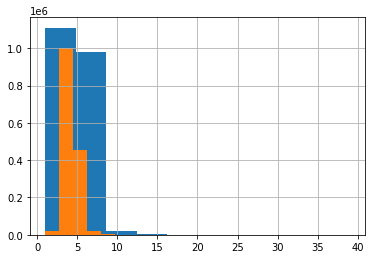

In [128]:
df3.groupby('class')['median_word_length'].hist()

In [124]:
#Export as 06_data_engineered_all7 (after median_word_length addition)
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_all7.parquet.gz'
df3.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

### DELETE

In [ ]:
#credit to https://www.kaggle.com/code/mathemilda/part-2-feature-engineering
def cleaning_and_counts(s):
    s = ftfy.fix_text(s)
    s = re.sub(dashes_compiled, '-', s)
    url_n = len(re.findall('https?://\\S+\\b', s))
    s = re.sub('https?://\\S+\\b', '', s)
    hasht_n = len(re.findall('#\S+', s))
    s = re.sub('#\S+', '', s)
    handle_n = len(re.findall('@([a-z0-9_]{1,15})\\b', s))
    s = re.sub('@([a-z0-9_]{1,15})\\b', '', s)
    exl_n = len(re.findall('!', s))
    s = re.sub('pic\\.twitter\\.com/\\w+\\b', '', s)
    s = re.sub('\\s+', ' ', s) #reducing multiple whitespaces to one
    s = s.lstrip(whitespace+punctuation+'\xa0'+chr(8230))
    s = s.rstrip(whitespace+'\xa0')
    l=''
    emoji_and_such = 0
    for ch in s:
        if ord(ch) < 8204:
            l += ch
        else:
            emoji_and_such += 1
    comma_n = len(re.findall(',', s))
    dash_n = len(re.findall('-', s)) # dropped spaces around the dash
    a_an_n = len(re.findall(r'\b[Aa]n?\b', s))
    the_n = len(re.findall(r'\b[Tt]he\b', s))
    # reduce a number of repeated symbols to no more than 2 
    l = re.sub(r'(.)\1\1+', r'\1\1', l)
    length = len(l)
    words = [len(w) for w in re.findall(r'\b\w+\b', l)]
    if len(words)==0:
        average_word = 0
    else:
        average_word = np.median(words)
    return l, url_n, hasht_n, handle_n, emoji_and_such\
        , exl_n, comma_n, dash_n\
        , a_an_n, the_n, length, average_word

In [ ]:
test_df3['tuple']= test_df3['content'].apply(cleaning_and_counts)

In [ ]:
test_df3[['tuple','content']]

,tuple,content
1647686,"(Trump DOJ Ignores Deadline, Says It Needs More Time To Find Nonexistent Wiretapping Evidence, 1, 0, 0, 0, 0, 1, 0, 0, 0, 92, 4.5)","Trump DOJ Ignores Deadline, Says It Needs More Time To Find Nonexistent Wiretapping Evidence https://t.co/Pj1gy4uEZ5"
1084378,"(Obama staffer @JonFavs spent 4 years in the White House after posting this on Facebook, 1, 0, 0, 0, 0, 0, 0, 0, 1, 86, 5.0)",Obama staffer @JonFavs spent 4 years in the White House after posting this on Facebook https://t.co/pwhuFLaN3K
375591,"(EU envoy blasts EU's 'lack of vision' on migration, 1, 1, 0, 0, 0, 0, 0, 0, 0, 50, 3.0)",EU envoy blasts EU’s ‘lack of vision’ on migration https://t.co/8ingIVWvNr #news
554657,"(White supremacist wanted to recruit racists for Times Square slaughter, 2, 0, 0, 0, 0, 0, 0, 0, 0, 70, 6.0)",White supremacist wanted to recruit racists for Times Square slaughter https://t.co/tn3s3Hryka https://t.co/MuUY2THF4a
301777,"(Spurs' Leonard back at practice, 2, 0, 0, 0, 0, 0, 0, 0, 0, 31, 5.0)",Spurs’ Leonard back at practice https://t.co/YdaMIyoQzS https://t.co/UKEPCIar0q
2138287,"(Great question! Yes, candles of any size are allowed in your carry-on bags. Good to go in checked bags too!, 0, 0, 1, 0, 2, 1, 1, 0, 0, 107, 4.0)","@wookiesncream Great question! Yes, candles of any size are allowed in your carry-on bags. Good to go in checked bags too!"
3590320,"(RT @Braves: Dan Uggla puts the on the board with a bang. Check out this 3-run shot in the 7th:, 1, 1, 0, 0, 0, 0, 1, 1, 3, 94, 3.0)",RT @Braves: Dan Uggla puts the #Braves on the board with a bang. Check out this 3-run shot in the 7th: http://t.co/Q5ShWB5Bta
2765677,"(Orbit_MOUVAA it was an overkill smg he picked wrong class and didn't even kill with it so it's irrelevant, 0, 0, 0, 0, 0, 0, 0, 1, 0, 105, 3.0)",@Orbit_MOUVAA it was an overkill smg he picked wrong class and didn't even kill with it so it's irrelevant
2503731,"(Without maternal mortality numbers, we lack a roadmap to prevent women from dying:, 2, 0, 0, 0, 0, 1, 0, 1, 0, 82, 5.0)","Without maternal mortality numbers, we lack a roadmap to prevent women from dying: https://t.co/QsX4HNc8u5 https://t.co/z1ObzVTULF"
3127369,"(RT @PPA_Live: Congrats to Pete Wootton of @DennisUK - winner of the PPA Great Leap Forward Award, 1, 1, 0, 0, 0, 0, 1, 0, 1, 96, 4.5)",RT @PPA_Live: Congrats to Pete Wootton of @DennisUK – winner of the PPA Great Leap Forward Award #PPAAwards https://t.co/AQZqwXa9ns


In [ ]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\'t", " not", text) # Change 't to 'not'
    text = re.sub(r'(@.*?)[\s]', ' ', text) # Remove @name
    #text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", " ", text) # remove digits
    #text = re.sub(r"[^\w\s\#]", "", text) #remove special characters except hashtags
    text = text.strip(" ")
    text = re.sub(' +',' ', text).strip() # get rid of multiple spaces and replace with a single
    return text

In [ ]:
test_df3['cleaned_tweet']= test_df3['content'].apply(clean_text)

In [ ]:
test_df3[['cleaned_tweet','content','class']]

,cleaned_tweet,content,class
1647686,"Trump DOJ Ignores Deadline, Says It Needs More Time To Find Nonexistent Wiretapping Evidence","Trump DOJ Ignores Deadline, Says It Needs More Time To Find Nonexistent Wiretapping Evidence https://t.co/Pj1gy4uEZ5",Troll
1084378,Obama staffer spent 4 years in the White House after posting this on Facebook,Obama staffer @JonFavs spent 4 years in the White House after posting this on Facebook https://t.co/pwhuFLaN3K,Troll
375591,EU envoy blasts EU’s ‘lack of vision’ on migration #news,EU envoy blasts EU’s ‘lack of vision’ on migration https://t.co/8ingIVWvNr #news,Troll
554657,White supremacist wanted to recruit racists for Times Square slaughter,White supremacist wanted to recruit racists for Times Square slaughter https://t.co/tn3s3Hryka https://t.co/MuUY2THF4a,Troll
301777,Spurs’ Leonard back at practice,Spurs’ Leonard back at practice https://t.co/YdaMIyoQzS https://t.co/UKEPCIar0q,Troll
2138287,"Great question! Yes, candles of any size are allowed in your carry-on bags. Good to go in checked bags too!","@wookiesncream Great question! Yes, candles of any size are allowed in your carry-on bags. Good to go in checked bags too!",Verified
3590320,RT Dan Uggla puts the #Braves on the board with a bang. Check out this 3-run shot in the 7th:,RT @Braves: Dan Uggla puts the #Braves on the board with a bang. Check out this 3-run shot in the 7th: http://t.co/Q5ShWB5Bta,Verified
2765677,it was an overkill smg he picked wrong class and didn not even kill with it so it's irrelevant,@Orbit_MOUVAA it was an overkill smg he picked wrong class and didn't even kill with it so it's irrelevant,Verified
2503731,"Without maternal mortality numbers, we lack a roadmap to prevent women from dying:","Without maternal mortality numbers, we lack a roadmap to prevent women from dying: https://t.co/QsX4HNc8u5 https://t.co/z1ObzVTULF",Verified
3127369,RT Congrats to Pete Wootton of – winner of the PPA Great Leap Forward Award #PPAAwards,RT @PPA_Live: Congrats to Pete Wootton of @DennisUK – winner of the PPA Great Leap Forward Award #PPAAwards https://t.co/AQZqwXa9ns,Verified


In [ ]:
 text = '@RTBOby 500 bucks for #penguins tickets is 4 more than I allow https://www.5tickets.com'
 text = re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", " ", text) # remove digits
 text

'@RTBOby   bucks for #penguins tickets is   more than I allow https://www.5tickets.com'

### 4 Subset for English Only Model

In [ ]:
len(df3)

3624894

In [ ]:
df3['language'].value_counts()

en     3623140
fr         397
tl         308
es         304
de         157
nl         117
in          83
pt          65
it          58
da          56
et          48
ht          43
eu          24
ca          18
sv          16
no          13
pl          12
cy          12
lt           4
tr           4
vi           4
lv           3
hu           2
cs           1
ko           1
hi           1
ro           1
und          1
zxx          1
Name: language, dtype: int64

In [129]:
#save as en_df for English only tweets
en_df = df3[df3['language']=='en']
len(en_df)

3623140

In [ ]:
en_df['account_category'].value_counts()

Verified_User    1470028
RightTroll        704953
NewsFeed          596593
LeftTroll         422141
HashtagGamer      236091
Commercial        112580
Unknown            43191
NonEnglish         26562
Fearmonger         11001
Name: account_category, dtype: int64

In [130]:
en_df=en_df[en_df['account_category']!='NonEnglish']
len(en_df)

3596578

In [ ]:
en_df['account_category'].value_counts()

Verified_User    1470028
RightTroll        704953
NewsFeed          596593
LeftTroll         422141
HashtagGamer      236091
Commercial        112580
Unknown            43191
Fearmonger         11001
NonEnglish             0
Name: account_category, dtype: int64

In [ ]:
#Export as 06_data_engineered_en (original)
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_en.parquet.gz'
en_df.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

In [131]:
#Export as 06_data_engineered_en2 (new features 2/27)
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_en2.parquet.gz'
en_df.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

### 5 Feature Selection for ML Model (Numeric, Binary, Categorical, Ordinal)

In [ ]:
#load en dataframe

#en_df = pd.read_parquet('/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_en.parquet.gz')
en_df = pd.read_parquet('/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_engineered_en2.parquet.gz')

In [ ]:
en_df.dtypes

external_author_id                    string
author                                string
content                               string
region                                string
language                            category
following                             uint64
followers                             uint64
updates                               uint64
post_type                           category
is_retweet                           float64
account_category                    category
tweet_id                              string
tco1_step1                            string
data_source                         category
has_url                                int64
emoji_text                            object
emoji_count                            int64
publish_date             datetime64[ns, UTC]
class                               category
following_ratio                      float64
class_numeric                           int8
RUS_lett_count                         int64
emoji_flag

In [133]:
en_df.describe()

,following,followers,updates,is_retweet,has_url,emoji_count,following_ratio,class_numeric,RUS_lett_count,emoji_flagUS,...,region_Global,region_Washington_DC,region_All_Other,multi_authors,num_dashes,num_commas,num_hashs,num_URL,num_URLs,median_word_length
count,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,...,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,3.596578e+06,3.596556e+06
mean,5.654078e+03,1.757067e+06,6.811728e+03,3.294159e-01,6.234440e-01,6.553869e-02,8.943565e-01,5.811925e-01,8.285654e-04,1.385484e-03,...,4.055800e-03,3.394894e-02,2.505534e-01,7.659336e-02,1.861900e-01,3.066637e-01,5.755610e-01,8.084090e-01,8.158450e-01,4.453334e+00
std,3.317921e+04,9.517599e+06,1.951992e+04,4.700012e-01,4.845221e-01,5.532249e-01,4.822668e+00,4.933638e-01,1.179797e-01,3.719630e-02,...,6.355589e-02,1.810978e-01,4.333318e-01,2.659452e-01,5.267582e-01,6.501866e-01,9.480190e-01,7.384369e-01,7.375958e-01,1.118185e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,4.730000e+02,1.182000e+03,9.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.525934e-02,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,1.437000e+03,1.155800e+04,1.080000e+03,0.000000e+00,1.000000e+00,0.000000e+00,3.860762e-01,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00
75%,4.583000e+03,5.991400e+04,6.258750e+03,1.000000e+00,1.000000e+00,0.000000e+00,9.348404e-01,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00
max,4.095338e+06,1.335241e+08,5.732199e+06,1.000000e+00,1.000000e+00,1.210000e+02,1.010000e+03,1.000000e+00,9.900000e+01,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.800000e+01,3.000000e+01,3.500000e+01,6.000000e+00,6.000000e+00,3.900000e+01


In [134]:
#convert updates to int64
en_df['updates']= en_df['updates'].astype(int)
en_df['is_retweet']=en_df['is_retweet'].astype(int)
en_df['followers']= en_df['followers'].astype(int)
en_df['following']= en_df['following'].astype(int)

In [ ]:
en_df.dtypes

external_author_id                    string
author                                string
content                               string
region                                string
language                            category
following                              int64
followers                              int64
updates                                int64
post_type                           category
is_retweet                             int64
account_category                    category
tweet_id                              string
tco1_step1                            string
data_source                         category
has_url                                int64
emoji_text                            object
emoji_count                            int64
publish_date             datetime64[ns, UTC]
class                               category
following_ratio                      float64
class_numeric                           int8
RUS_lett_count                         int64
emoji_flag

KEEP

In [135]:
#determine column types to keep
target = ['class_numeric']
columns_without_target = list(en_df[en_df.columns.difference(target)])
num_attribs = list(en_df[columns_without_target].select_dtypes(include=['int64','float64']).columns)
#cat_attribs = list(en_df[columns_without_target].select_dtypes(include=['object']).columns)
target_column = en_df['class_numeric']

In [136]:
#remove columns not being used
columns_to_drop = list(en_df[en_df.columns.difference(num_attribs)])
columns_to_drop.remove('class_numeric')
columns_to_drop

['account_category',
 'author',
 'class',
 'content',
 'data_source',
 'emoji_text',
 'external_author_id',
 'language',
 'post_type',
 'publish_date',
 'region',
 'tco1_step1',
 'tweet_id']

In [137]:
#retain the author and ID for use later
cols_for_later = columns_to_drop.copy()
cols_for_later.remove('external_author_id')
cols_for_later.remove('tweet_id')
cols_for_later.remove('author')
cols_for_later

['account_category',
 'class',
 'content',
 'data_source',
 'emoji_text',
 'language',
 'post_type',
 'publish_date',
 'region',
 'tco1_step1']

In [ ]:
full_final_df = en_df.drop(columns= cols_for_later, axis =1)
full_final_df.columns

Index(['external_author_id', 'author', 'following', 'followers', 'updates',
       'is_retweet', 'tweet_id', 'has_url', 'emoji_count', 'following_ratio',
       'class_numeric', 'RUS_lett_count', 'emoji_flagUS', 'emoji_police',
       'emoji_check', 'emoji_exclamation', 'emoji_fist', 'emoji_collision',
       'emoji_prohibited', 'emoji_loudcryface', 'emoji_fire', 'emoji_redheart',
       'emoji_tearsjoy', 'emoji_thumbsup', 'emoji_claphands',
       'emoji_blowingkiss', 'emoji_partypop', 'emoji_raisehands',
       'emoji_troll', 'unknown_location', 'multi_authors',
       'emoji_smilinghearteye'],
      dtype='object')

In [139]:
full_final_df = en_df.drop(columns= cols_for_later, axis =1)
full_final_df = full_final_df.drop(columns = 'num_URL', axis = 1)
full_final_df.columns

Index(['external_author_id', 'author', 'following', 'followers', 'updates',
       'is_retweet', 'tweet_id', 'has_url', 'emoji_count', 'following_ratio',
       'class_numeric', 'RUS_lett_count', 'emoji_flagUS', 'emoji_police',
       'emoji_check', 'emoji_exclamation', 'emoji_fist', 'emoji_collision',
       'emoji_prohibited', 'emoji_loudcryface', 'emoji_smilinghearteye',
       'emoji_fire', 'emoji_redheart', 'emoji_tearsjoy', 'emoji_thumbsup',
       'emoji_claphands', 'emoji_blowingkiss', 'emoji_partypop',
       'emoji_raisehands', 'region_United_States', 'region_Unknown',
       'region_New_York_NY', 'region_United_Kingdom', 'region_Los_Angeles_CA',
       'region_Boston_MA', 'region_London', 'region_New_York_and_the_World',
       'region_New_York_City', 'region_Pale_Blue_Dot', 'region_Atlanta_GA',
       'region_Australia', 'region_Global', 'region_Washington_DC',
       'region_All_Other', 'multi_authors', 'num_dashes', 'num_commas',
       'num_hashs', 'num_URLs', 'median_wo

In [ ]:
#export final_df for use in 07_ML_models NB as 06data_final_en.parquet.gz
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_full_final_en.parquet.gz'
full_final_df.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

In [140]:
#export final_df for use in 07_ML_models NB as 06data_final_en2.parquet.gz (updated 2/27)
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_full_final_en2.parquet.gz'
full_final_df.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

In [ ]:
final_df = en_df.drop(columns = columns_to_drop, axis =1)
final_df.columns

Index(['following', 'followers', 'updates', 'is_retweet', 'has_url',
       'emoji_count', 'following_ratio', 'class_numeric', 'RUS_lett_count',
       'emoji_flagUS', 'emoji_police', 'emoji_check', 'emoji_exclamation',
       'emoji_fist', 'emoji_collision', 'emoji_prohibited',
       'emoji_loudcryface', 'emoji_fire', 'emoji_redheart', 'emoji_tearsjoy',
       'emoji_thumbsup', 'emoji_claphands', 'emoji_blowingkiss',
       'emoji_partypop', 'emoji_raisehands', 'emoji_troll', 'unknown_location',
       'multi_authors', 'emoji_smilinghearteye'],
      dtype='object')

In [ ]:
#export final_df for use in 07_ML_models NB as 06data_final_en.parquet.gz
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_final_en.parquet.gz'
final_df.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

In [141]:
final_df = en_df.drop(columns = columns_to_drop, axis =1)
final_df.columns

Index(['following', 'followers', 'updates', 'is_retweet', 'has_url',
       'emoji_count', 'following_ratio', 'class_numeric', 'RUS_lett_count',
       'emoji_flagUS', 'emoji_police', 'emoji_check', 'emoji_exclamation',
       'emoji_fist', 'emoji_collision', 'emoji_prohibited',
       'emoji_loudcryface', 'emoji_smilinghearteye', 'emoji_fire',
       'emoji_redheart', 'emoji_tearsjoy', 'emoji_thumbsup', 'emoji_claphands',
       'emoji_blowingkiss', 'emoji_partypop', 'emoji_raisehands',
       'region_United_States', 'region_Unknown', 'region_New_York_NY',
       'region_United_Kingdom', 'region_Los_Angeles_CA', 'region_Boston_MA',
       'region_London', 'region_New_York_and_the_World',
       'region_New_York_City', 'region_Pale_Blue_Dot', 'region_Atlanta_GA',
       'region_Australia', 'region_Global', 'region_Washington_DC',
       'region_All_Other', 'multi_authors', 'num_dashes', 'num_commas',
       'num_hashs', 'num_URL', 'num_URLs', 'median_word_length'],
      dtype='object'

In [142]:
final_df.shape

(3596578, 48)

In [143]:
#export final_df for use in 07_ML_models NB as 06data_final_en.parquet.gz (updated 2/27 features)
parq_path = '/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_final_en2.parquet.gz'
final_df.to_parquet(parq_path, engine='pyarrow', index=False, compression='gzip')

### DELETE
6 Account vs. Tweet ML Model Dataset

In [6]:
full_df = pd.read_parquet('/content/gdrive/MyDrive/Grad School/DSCI592/data/06data_full_final_en.parquet.gz')

In [ ]:
full_df.columns

Index(['external_author_id', 'author', 'updates', 'is_retweet', 'tweet_id',
       'has_url', 'emoji_count', 'following_ratio', 'class_numeric',
       'RUS_lett_count', 'emoji_flagUS', 'emoji_police', 'emoji_check',
       'emoji_exclamation', 'emoji_fist', 'emoji_collision',
       'emoji_prohibited', 'emoji_loudcryface', 'emoji_smilinghearteye',
       'emoji_fire', 'emoji_redheart', 'emoji_tearsjoy', 'emoji_thumbsup',
       'emoji_claphands', 'emoji_blowingkiss', 'emoji_partypop',
       'emoji_raisehands', 'emoji_troll', 'unknown_location', 'multi_authors'],
      dtype='object')

In [ ]:
full_df.groupby('external_author_id')['tweet_id'].count().nsmallest(110000)

external_author_id
1000074404    1
100014747     1
100039185     1
100084529     1
100124640     1
             ..
110301857     9
110345556     9
110498445     9
110711694     9
110723010     9
Name: tweet_id, Length: 110000, dtype: int64

In [ ]:
full_df.external_author_id.nunique()

140858

In [7]:
full_df.groupby('class_numeric')['external_author_id'].nunique()

class_numeric
0    139736
1      1122
Name: external_author_id, dtype: int64